In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

## Read in Data

CELLPOSE

In [2]:
# Load the dataframe from the csv file
file_name = "cellpose_results/cellpose_run04_240427113411.csv"
df = pd.read_csv(file_name)
df['scribbles bin'] = df['scribbles bin'].replace({1.25: 10})
display(df[:5])
print(df.shape)
df_orig = df.copy() 

,img_num,prediction type,scribbles mode,scribbles bin,suffix,max_class_pix_gt,min_class_pix_gt,pix_labelled,max_class_pix_labelled,min_class_pix_labelled,pix_in_img,perc. labelled,accuracy,scribbles,prediction
0,0,convpaint_l-0_s-1,all,0.058,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.808197,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
1,0,convpaint_l-0_s-1-2,all,0.058,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.811732,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
2,0,convpaint_l-0_s-1-2-4,all,0.058,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.817520,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
3,0,convpaint_l-0_s-1-2-4-8,all,0.058,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.684402,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
4,0,convpaint_l-0-2_s-1,all,0.058,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.818532,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...


(19320, 15)


FoodSeg103

In [30]:
file_name = "FoodSeg103_results/food_run04_240428133857.csv"
df = pd.read_csv(file_name)
df['scribbles bin'] = df['scribbles bin'].replace({0.058: 0.25, 0.25: 1, 1.4: 5})
df_defaultCP = df.copy()
df_defaultCP = df_defaultCP.loc[(df_defaultCP['prediction type'] == 'ilastik') | (df_defaultCP['prediction type'] == 'convpaint_l-0_s-1-2')]
df_defaultCP['prediction type'] = df_defaultCP['prediction type'].replace({'convpaint_l-0_s-1-2': 'convpaint'})


In [7]:
df.groupby('scribbles bin').agg({'perc. labelled': 'mean'})

,perc. labelled
scribbles bin,
0.25,0.247791
1.00,0.973125
5.00,4.958578


In [2]:
# Load the dataframe from the csv file
file_name = "FoodSeg103_results/food_run03_240414211610.csv"
df = pd.read_csv(file_name)
df = df.loc[(df['prediction type'] == 'ilastik') | (df['prediction type'] == 'convpaint_l-0_s-1-2')]
df['prediction type'] = df['prediction type'].replace({'convpaint_l-0_s-1-2': 'convpaint'})

# food_annot_bins = [round(bin, 1) for bin in df.groupby('scribbles bin').mean('perc. labelled')['perc. labelled']]
food_annot_bins = {bin: round(df[df['scribbles bin'] == bin]['perc. labelled'].mean(), 1) for bin in df['scribbles bin'].unique()}
df['scribbles bin'] = df['scribbles bin'].replace(food_annot_bins)

display(df[:5])
print(df.shape)
df_orig = df.copy()

,img_num,prediction type,scribbles mode,scribbles bin,suffix,max_class_pix_gt,min_class_pix_gt,pix_labelled,max_class_pix_labelled,min_class_pix_labelled,pix_in_img,perc. labelled,accuracy,scribbles,prediction
1,0,convpaint,all,0.2,w3,73227,29097,349,196259,50,196608,0.177511,0.799942,/home/rschwob/scribbles_tests/food_results/run...,/home/rschwob/scribbles_tests/food_results/run...
8,0,ilastik,all,0.2,w3,73227,29097,349,196259,50,196608,0.177511,0.501175,/home/rschwob/scribbles_tests/food_results/run...,/home/rschwob/scribbles_tests/food_results/run...
11,0,convpaint,all,1.0,w3,73227,29097,2029,194579,367,196608,1.032003,0.868764,/home/rschwob/scribbles_tests/food_results/run...,/home/rschwob/scribbles_tests/food_results/run...
18,0,ilastik,all,1.0,w3,73227,29097,2029,194579,367,196608,1.032003,0.773066,/home/rschwob/scribbles_tests/food_results/run...,/home/rschwob/scribbles_tests/food_results/run...
21,0,convpaint,all,5.2,w3,73227,29097,10678,185930,1610,196608,5.431112,0.939809,/home/rschwob/scribbles_tests/food_results/run...,/home/rschwob/scribbles_tests/food_results/run...


(2754, 15)


## Check distribution of Convpaint (default) accuracies among the dataset

Convpaint

Text(0, 0.5, 'Accuracy')

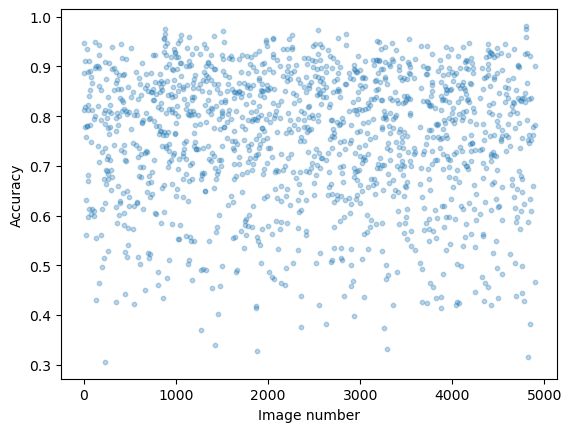

In [9]:
# df_conv =  df[df['prediction type'].str.contains('convpaint')]# & (df['scribbles bin'] == 1)]
df_conv =  df[df['prediction type'] == 'convpaint_l-0_s-1-2']# & (df['scribbles bin'] == 1)]
# plt.figure(figsize=(5, 3), dpi=300)
plt.scatter(df_conv['img_num'], df_conv['accuracy'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel('Accuracy')

Add column with difference between Convpaint (default) and Ilastik accuracies

In [10]:
df_diff = df.copy()
# df_diff = df_diff[df_diff['prediction type'].str.contains('convpaint_l-0_s-1-2') | df_diff['prediction type'].str.contains('ilastik')]
df_diff = df_diff[(df_diff['prediction type'] == 'convpaint_l-0_s-1-2') | df_diff['prediction type'].str.contains('ilastik')]

# Add ilastik accuracy on the same row as convpaint accuracy as a new column ("acc. ilastik")
for scr in df_diff['scribbles']:
    acc_il = df_diff.loc[(df_diff['scribbles'] == scr) & (df_diff['prediction type'] == "ilastik"), "accuracy"].values[0]
    df_diff.loc[(df_diff['scribbles'] == scr) & (df_diff['prediction type'].str.contains("convpaint")), "acc. ilastik"] = acc_il

# Rename the "accuracy" column to "acc. convpaint"
df_diff.rename(columns={"accuracy": "acc. convpaint"}, inplace=True)
# Add difference between convpaint and ilastik accuracy in a new column ("acc. diff")
df_diff["acc. diff"] = df_diff["acc. convpaint"] - df_diff["acc. ilastik"]

# Move the columns (optional, and needs exactly these column names)
# df_diff = df_diff[["img_num", "scribbles mode", "scribbles bin", "suffix", "class_1_pix_gt", "class_2_pix_gt", "pix_labelled", "class_1_pix_labelled", "class_2_pix_labelled", "pix_in_img", "perc. labelled", "acc. convpaint", "acc. ilastik", "acc. diff", "image", "ground truth", "scribbles"]]

# Remove Ilastik rows
df_diff = df_diff[df_diff["prediction type"].str.contains("convpaint")]

Text(0, 0.5, 'Accuracy diff.')

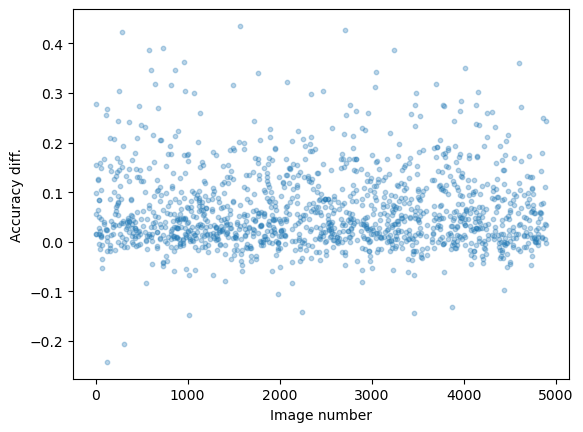

In [11]:
plt.scatter(x = df_diff['img_num'], y = df_diff['acc. diff'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel('Accuracy diff.')

## Compare convpaint to ilastik (accuracies)

Check if there is a correlation between pixels labelled - mostly makes sense to check within bins...

In [12]:
df_diff_bin = df_diff[df_diff["scribbles bin"] == 1]

Cellpose: In one or the other class (not working for FoodSeg103 with multiple classes)

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_diff_bin["class_1_pix_labelled"], df_diff_bin["acc. diff"], alpha=0.3, s=10, c="red", label="background")
plt.scatter(df_diff_bin["class_2_pix_labelled"], df_diff_bin["acc. diff"], alpha=0.3, s=10, c = "blue", label="foreground")
plt.xlabel("Number of labelled pixels")
plt.xscale("log")
plt.hlines(0, 0, np.max([np.max(df_diff_bin["class_1_pix_labelled"]), np.max(df_diff_bin["class_1_pix_labelled"])]), colors='grey', linestyles='dashed')
plt.ylabel("Accuracy difference (convpaint - ilastik)")
plt.legend()

In the minimum/maximum among classes

In [ ]:
df_diff_bin.loc[:,'min_class_pix_labelled'] = df_diff_bin[['class_1_pix_labelled', 'class_2_pix_labelled']].min(axis=1)#.astype(int)
df_diff_bin.loc[:,'max_class_pix_labelled'] = df_diff_bin[['class_1_pix_labelled', 'class_2_pix_labelled']].max(axis=1)#.astype(int)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
ax1.scatter(x = df_diff_bin['min_class_pix_labelled'], y = df_diff_bin['acc. diff'], alpha=0.3, s=10)
ax1.set_xlabel("Number of labelled pixels (minimum among classes)")
# ax1.set_xscale("log")
ax1.hlines(0, np.min(df_diff_bin['min_class_pix_labelled']), np.max(df_diff_bin['min_class_pix_labelled']), colors='grey', linestyles='dashed')
ax1.set_ylabel("Accuracy difference (convpaint - ilastik)")
ax2.scatter(x = df_diff_bin['max_class_pix_labelled'], y = df_diff_bin['acc. diff'], alpha=0.3, s=10)
ax2.set_xlabel("Number of labelled pixels (maximum among classes)")
# ax2.set_xscale("log")
ax2.hlines(0, np.min(df_diff_bin['max_class_pix_labelled']), np.max(df_diff_bin['max_class_pix_labelled']), colors='grey', linestyles='dashed')
ax2.set_ylabel("Accuracy difference (convpaint - ilastik)")

Check if there is a correlation with the resolution (number pixels) of the image

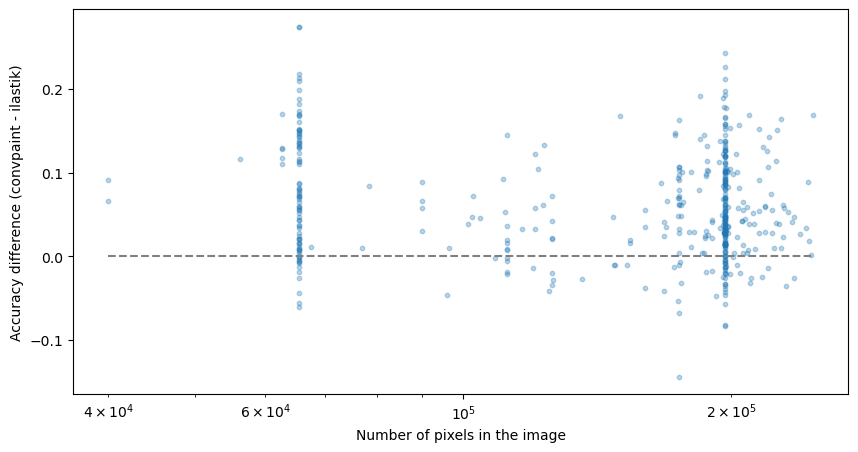

In [15]:
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_diff_bin["pix_in_img"], df_diff_bin["acc. diff"], alpha=0.3, s=10)
plt.xlabel("Number of pixels in the image")
plt.ylabel("Accuracy difference (convpaint - ilastik)")
plt.hlines(0, np.min(df_diff_bin["pix_in_img"]), np.max(df_diff_bin["pix_in_img"]), colors='grey', linestyles='dashed')
plt.xscale("log")

Check in which cases the difference is the highest

In [33]:
# df_diff[df_diff['acc. convpaint'] < 0.6].sort_values(by="acc. diff", ascending=True)['image'].shape
df_diff[df_diff['scribbles bin'] > 0].sort_values(by="acc. diff", ascending=True)[0:10]

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,acc. convpaint,image,ground truth,scribbles,prediction,acc. ilastik,acc. diff
21057,188,convpaint_l-0_s-1-2,all,0.010,w1_run04,39964,10364,6,3,3,50328,0.011922,0.207419,/mnt/imaging.data/rschwob/cellpose_run04/188_i...,/mnt/imaging.data/rschwob/cellpose_run04/188_g...,/mnt/imaging.data/rschwob/cellpose_run04/188_s...,/mnt/imaging.data/rschwob/cellpose_run04/188_c...,0.939874,-0.732455
56001,500,convpaint_l-0_s-1-2,all,0.010,w1_run04,5240,45385,6,3,3,50625,0.011852,0.132978,/mnt/imaging.data/rschwob/cellpose_run04/500_i...,/mnt/imaging.data/rschwob/cellpose_run04/500_g...,/mnt/imaging.data/rschwob/cellpose_run04/500_s...,/mnt/imaging.data/rschwob/cellpose_run04/500_c...,0.848988,-0.716010
36289,324,convpaint_l-0_s-1-2,all,0.010,w1_run04,198099,64045,21,15,6,262144,0.008011,0.215088,/mnt/imaging.data/rschwob/cellpose_run04/324_i...,/mnt/imaging.data/rschwob/cellpose_run04/324_g...,/mnt/imaging.data/rschwob/cellpose_run04/324_s...,/mnt/imaging.data/rschwob/cellpose_run04/324_c...,0.862720,-0.647633
30129,269,convpaint_l-0_s-1-2,all,0.010,w1_run04,8289,42151,6,3,3,50440,0.011895,0.233168,/mnt/imaging.data/rschwob/cellpose_run04/269_i...,/mnt/imaging.data/rschwob/cellpose_run04/269_g...,/mnt/imaging.data/rschwob/cellpose_run04/269_s...,/mnt/imaging.data/rschwob/cellpose_run04/269_c...,0.802795,-0.569627
20609,184,convpaint_l-0_s-1-2,all,0.010,w1_run04,30146,14954,6,3,3,45100,0.013304,0.385654,/mnt/imaging.data/rschwob/cellpose_run04/184_i...,/mnt/imaging.data/rschwob/cellpose_run04/184_g...,/mnt/imaging.data/rschwob/cellpose_run04/184_s...,/mnt/imaging.data/rschwob/cellpose_run04/184_c...,0.881796,-0.496142
10529,94,convpaint_l-0_s-1-2,all,0.010,w1_run04,82307,77693,12,6,6,160000,0.007500,0.336044,/mnt/imaging.data/rschwob/cellpose_run04/094_i...,/mnt/imaging.data/rschwob/cellpose_run04/094_g...,/mnt/imaging.data/rschwob/cellpose_run04/094_s...,/mnt/imaging.data/rschwob/cellpose_run04/094_c...,0.818844,-0.482800
29681,265,convpaint_l-0_s-1-2,all,0.010,w1_run04,30017,20535,6,3,3,50552,0.011869,0.318286,/mnt/imaging.data/rschwob/cellpose_run04/265_i...,/mnt/imaging.data/rschwob/cellpose_run04/265_g...,/mnt/imaging.data/rschwob/cellpose_run04/265_s...,/mnt/imaging.data/rschwob/cellpose_run04/265_c...,0.771265,-0.452979
21505,192,convpaint_l-0_s-1-2,all,0.010,w1_run04,59824,59576,6,3,3,119400,0.005025,0.506549,/mnt/imaging.data/rschwob/cellpose_run04/192_i...,/mnt/imaging.data/rschwob/cellpose_run04/192_g...,/mnt/imaging.data/rschwob/cellpose_run04/192_s...,/mnt/imaging.data/rschwob/cellpose_run04/192_c...,0.908668,-0.402119
37857,338,convpaint_l-0_s-1-2,all,0.010,w1_run04,27355,185637,19,3,16,212992,0.008921,0.512986,/mnt/imaging.data/rschwob/cellpose_run04/338_i...,/mnt/imaging.data/rschwob/cellpose_run04/338_g...,/mnt/imaging.data/rschwob/cellpose_run04/338_s...,/mnt/imaging.data/rschwob/cellpose_run04/338_c...,0.864079,-0.351093
29359,262,convpaint_l-0_s-1-2,all,0.025,w1_run04,4222,35778,9,3,6,40000,0.022500,0.222725,/mnt/imaging.data/rschwob/cellpose_run04/262_i...,/mnt/imaging.data/rschwob/cellpose_run04/262_g...,/mnt/imaging.data/rschwob/cellpose_run04/262_s...,/mnt/imaging.data/rschwob/cellpose_run04/262_c...,0.563450,-0.340725


## Compare bins

In [16]:
df_diff_copy = df_diff.copy()

### Convpaint-Ilastik difference

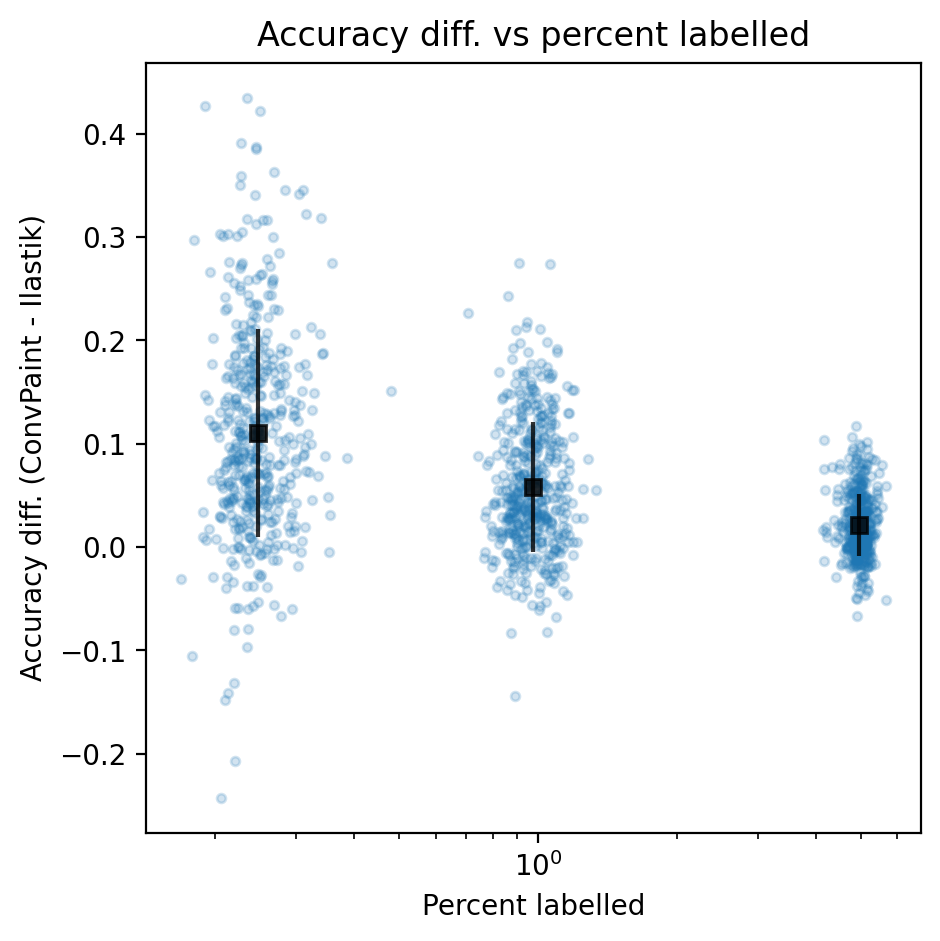

In [17]:
# Plot the data in matplotlib scatter plot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
# # set dpi
fig.set_dpi(200)

# scatter_ax = ax[0]
# sns.scatterplot(x="acc. convpaint", y="acc. ilastik", hue="scribbles bin", data=df_diff_copy, palette="viridis", s=30, alpha=0.8, ax=scatter_ax, legend=False, marker='.')
# # scatter_ax.scatter(df_diff_copy['acc. convpaint'], df_diff_copy['acc. ilastik'], c=df_diff_copy['scribbles bin'], cmap='viridis', s=20, alpha=0.7)
# scatter_ax.plot([0, 1], [0, 1], transform=scatter_ax.transAxes, c='black', alpha=0.5)
# scatter_ax.set_xlabel("Accuracy ConvPaint")
# scatter_ax.set_ylabel("Accuracy Ilastik")
# scatter_ax.set_title("Accuracy ConvPaint vs Accuracy Ilastik")

diff_ax = ax
diff_ax.scatter(df_diff_copy['perc. labelled'], df_diff_copy['acc. diff'], alpha=0.2, s=10)
df_grouped = df_diff_copy.groupby('scribbles bin').agg({'acc. diff': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
diff_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['acc. diff']['mean'], yerr=df_grouped['acc. diff']['std'], fmt='s', c='black', alpha=0.8)
diff_ax.set_xscale('log')
diff_ax.set_xlabel('Percent labelled')
diff_ax.set_ylabel('Accuracy diff. (ConvPaint - Ilastik)')
diff_ax.set_title(f'Accuracy diff. vs percent labelled')
plt.show()

### Convpaint and Ilastik on separate plots

In [18]:
# Filter out some bins
# df = df[df['scribbles bin'] != 0.01]
# df = df[df['scribbles bin'] != 1]
# df = df[df['class_1_pix_labelled'] >= 5]
# df = df[df['class_2_pix_labelled'] >= 5]
# Change the values of the prediction types to be more readable
# df['prediction type'] = df['prediction type'].apply(lambda x: "convpaint" if x == "convpaintCh1" else "classic filters")

# Take only the default ConvPaint
df = df[(df['prediction type'] == 'convpaint_l-0_s-1-2') | (df['prediction type'] == 'ilastik')]
# Change scribbles bin 1.25 to 10 (because we widened the scribbles accordingly)
df['scribbles bin'] = df['scribbles bin'].replace({1.25: 10})

# Create two filtered dataframes
df['prediction type'] = df['prediction type'].apply(lambda x: "classic filters" if x == "ilastik" else x)
df_convpaint = df[df['prediction type'].str.contains('convpaint')]
df_ilastik = df[df['prediction type'].str.contains('classic filters')]
df[:10]

,img_num,prediction type,scribbles mode,scribbles bin,suffix,max_class_pix_gt,min_class_pix_gt,pix_labelled,max_class_pix_labelled,min_class_pix_labelled,pix_in_img,perc. labelled,accuracy,scribbles,prediction
1,0,convpaint_l-0_s-1-2,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.811732,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
12,0,classic filters,all,0.25,w3_run04,73227,29097,464,196144,71,196608,0.236003,0.795944,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_ilas...
15,0,convpaint_l-0_s-1-2,all,1.00,w3_run04,73227,29097,2267,194341,280,196608,1.153056,0.887049,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
26,0,classic filters,all,1.00,w3_run04,73227,29097,2267,194341,280,196608,1.153056,0.731562,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_ilas...
29,0,convpaint_l-0_s-1-2,all,5.00,w3_run04,73227,29097,9901,186707,1398,196608,5.035909,0.946309,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_conv...
40,0,classic filters,all,5.00,w3_run04,73227,29097,9901,186707,1398,196608,5.035909,0.930567,/mnt/imaging.data/rschwob/food_run04/0000_scri...,/mnt/imaging.data/rschwob/food_run04/0000_ilas...
43,8,convpaint_l-0_s-1-2,all,0.25,w3_run04,99419,12157,521,200183,26,200704,0.259586,0.777528,/mnt/imaging.data/rschwob/food_run04/0008_scri...,/mnt/imaging.data/rschwob/food_run04/0008_conv...
54,8,classic filters,all,0.25,w3_run04,99419,12157,521,200183,26,200704,0.259586,0.499078,/mnt/imaging.data/rschwob/food_run04/0008_scri...,/mnt/imaging.data/rschwob/food_run04/0008_ilas...
57,8,convpaint_l-0_s-1-2,all,1.00,w3_run04,99419,12157,2167,198537,148,200704,1.079699,0.817916,/mnt/imaging.data/rschwob/food_run04/0008_scri...,/mnt/imaging.data/rschwob/food_run04/0008_conv...
68,8,classic filters,all,1.00,w3_run04,99419,12157,2167,198537,148,200704,1.079699,0.719866,/mnt/imaging.data/rschwob/food_run04/0008_scri...,/mnt/imaging.data/rschwob/food_run04/0008_ilas...


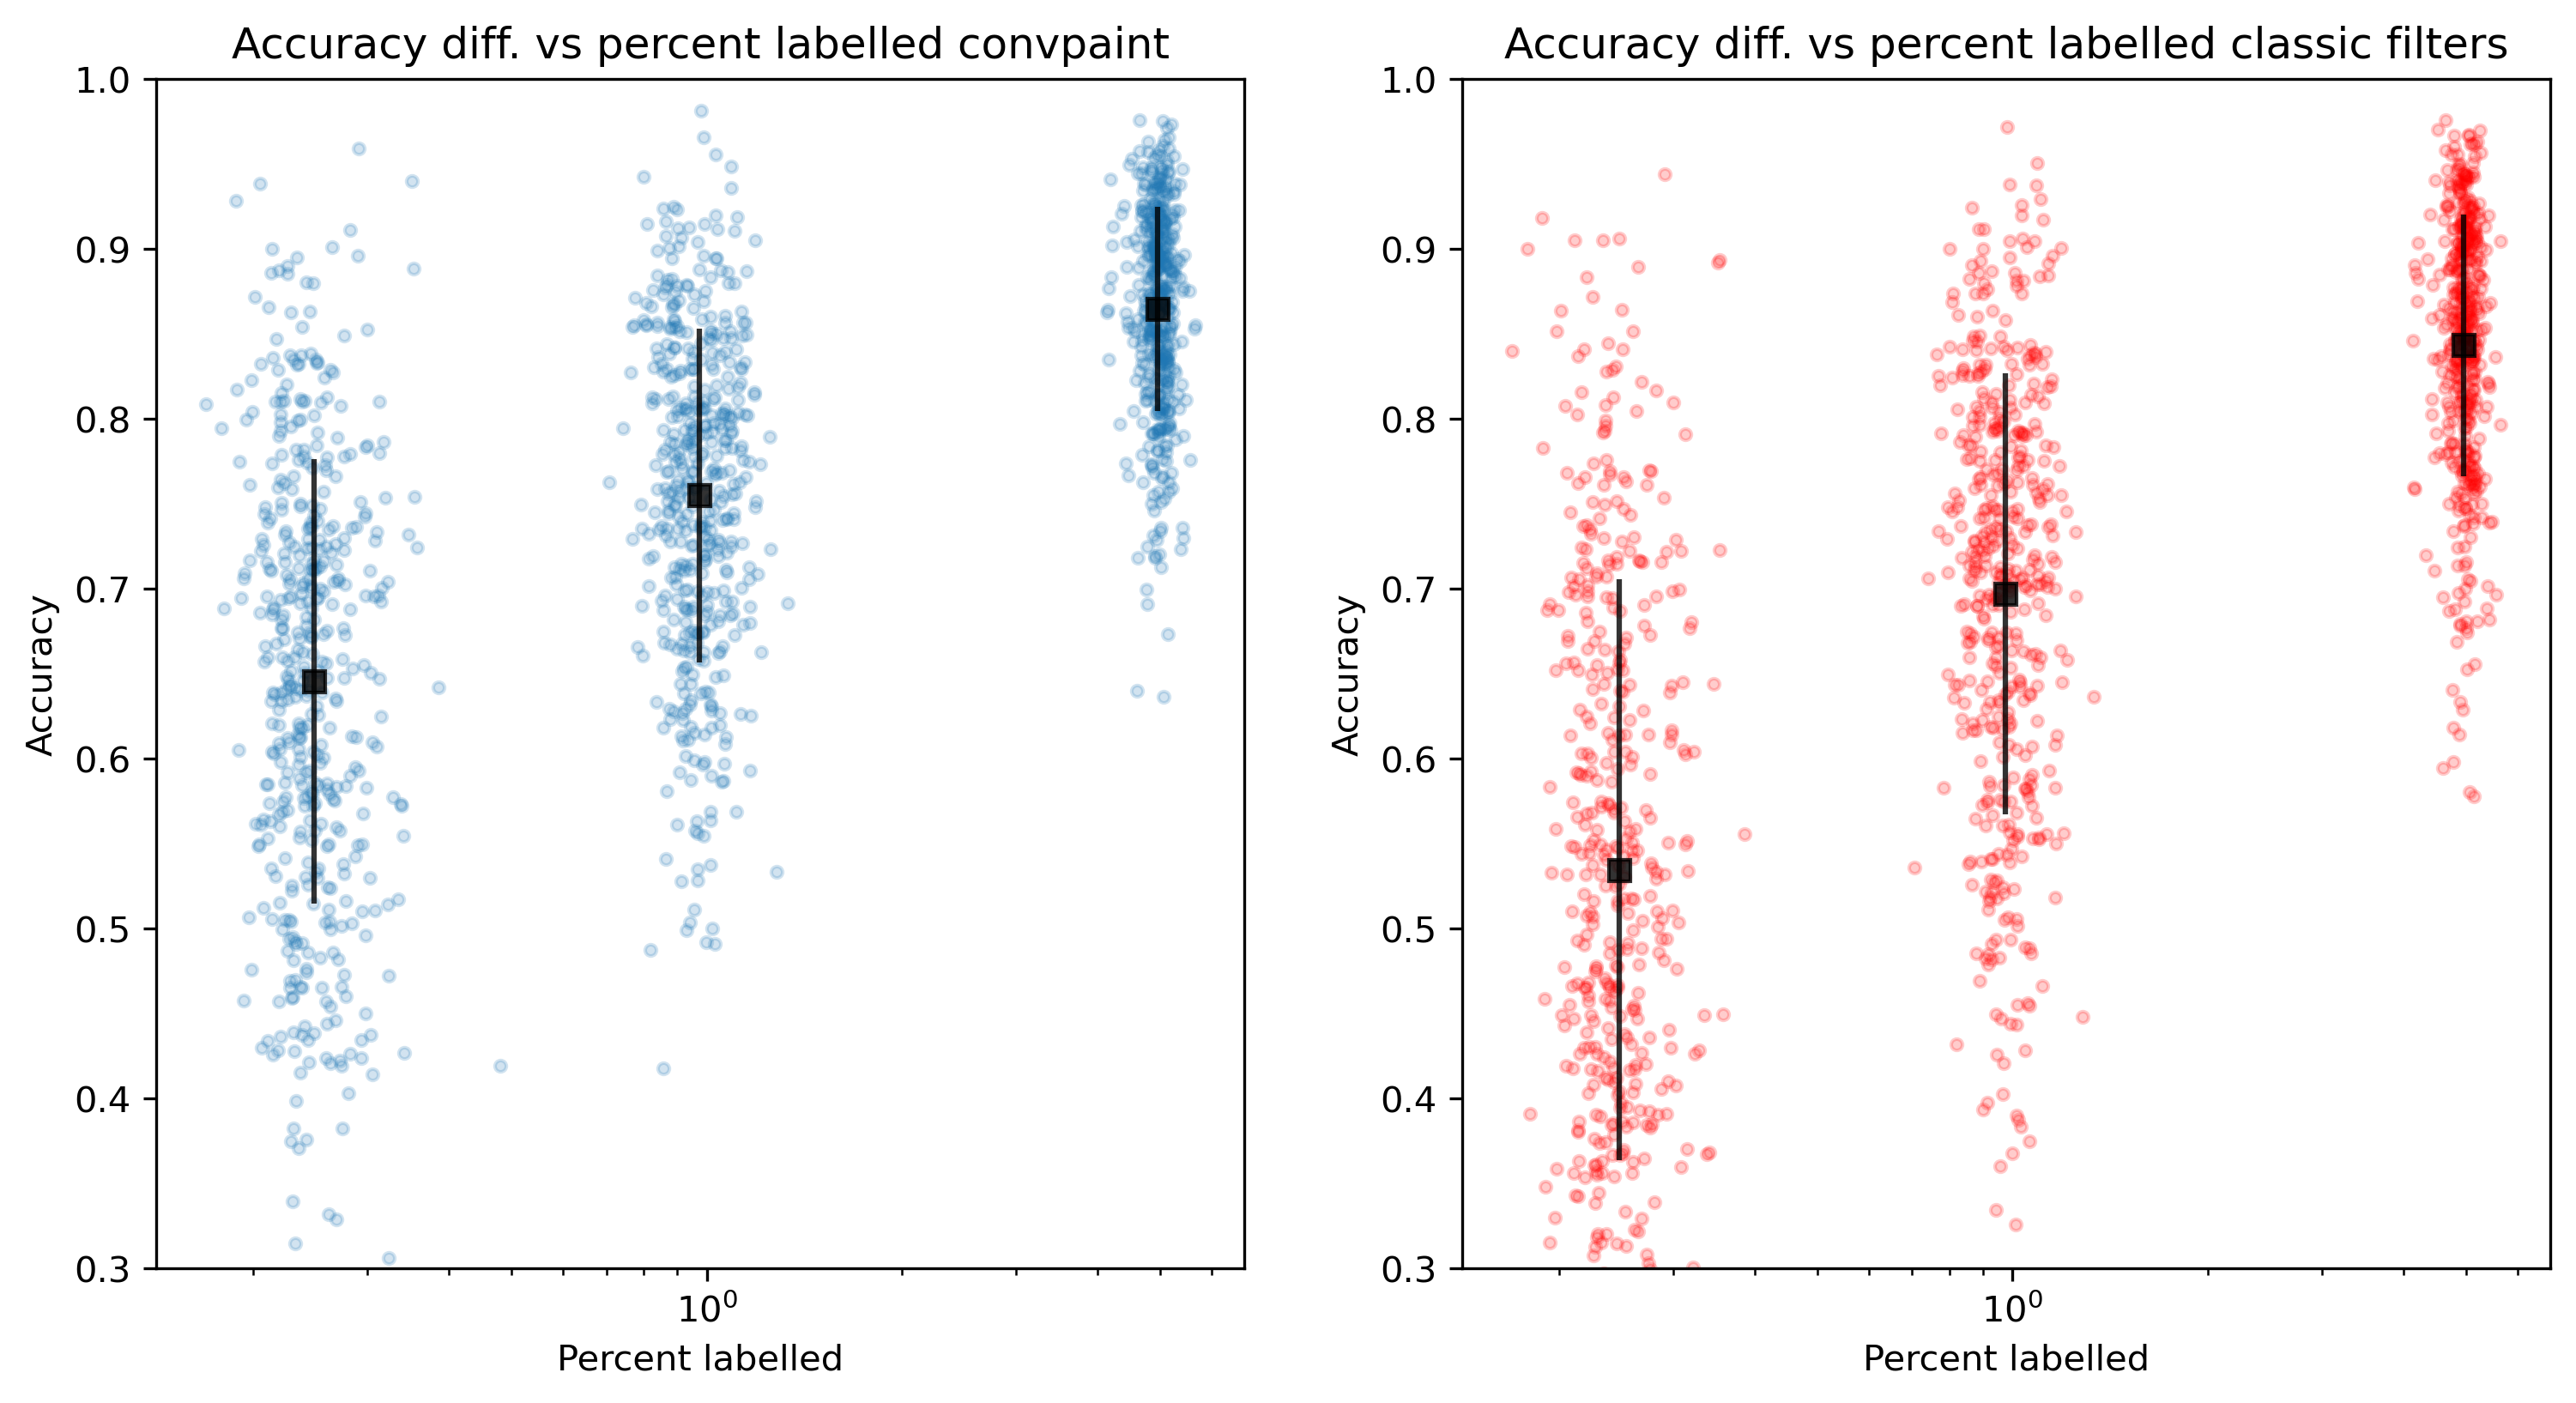

In [19]:
def plot_accuracy_vs_perc_labelled(df, pred_to_show="convpaint", plt_ax=None, **kwargs):
    if plt_ax is None:
        plt_ax = plt.subplots(1, 1)[1]
    # Plot accuracy vs percent labelled
    df_filtered = df[df['prediction type'].str.contains(pred_to_show)]

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered['accuracy'], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({'accuracy': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0.3, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel('Accuracy')
    plt_ax.set_title(f'Accuracy diff. vs percent labelled {pred_to_show}')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
fig.set_dpi(300)
plot_accuracy_vs_perc_labelled(df, 'convpaint', plt_ax=ax[0])
plot_accuracy_vs_perc_labelled(df, 'classic filters', plt_ax=ax[1], c='red')
# plt.savefig('results/accuracy_vs_perc_labelled.pdf', dpi=300)
plt.show()


### Convpaint and Ilastik on same plot

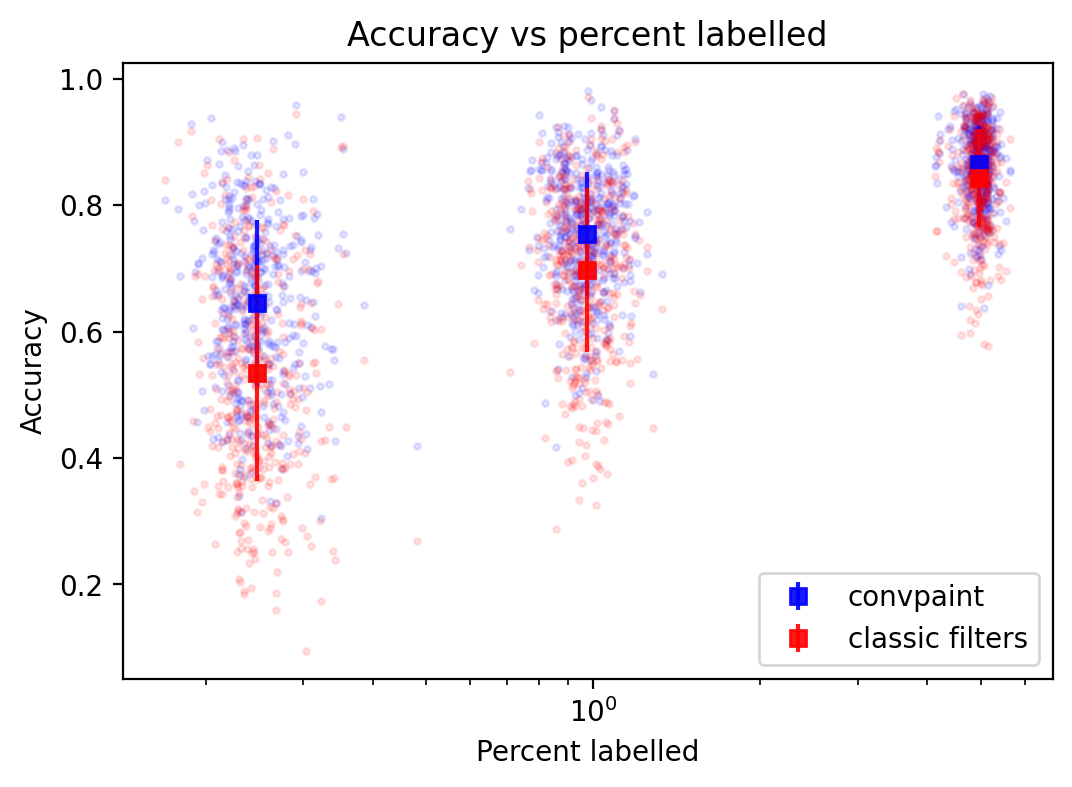

In [20]:
# Plot accuracy vs percent labelled
plt.figure(figsize=(6,4),dpi=200)

# ADD CONVPAINT PLOT
# Scatterplot
plt.scatter(df_convpaint['perc. labelled'], df_convpaint['accuracy'], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_convpaint.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='blue', alpha=0.9, label='convpaint')
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD ILASTIK PLOT
# Scatterplot
plt.scatter(df_ilastik['perc. labelled'], df_ilastik['accuracy'], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_ilastik.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='red', alpha=0.9, label='classic filters')
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.legend()
plt.show()

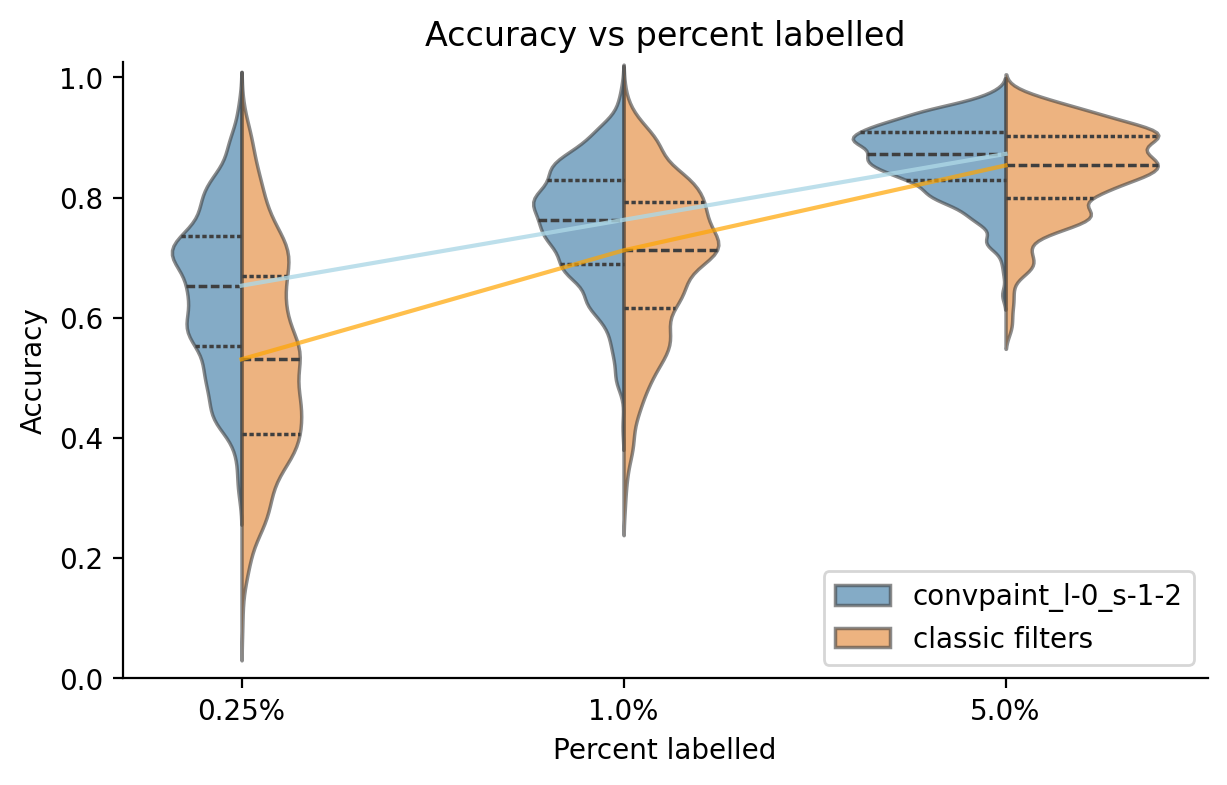

In [22]:
# Add a [0,0] point to the grouped dataframes manually
# df_convpaint_grouped = pd.concat([pd.DataFrame({'scribbles bin': [0], 'accuracy': [0]}), df_convpaint_grouped], ignore_index=True)
# df_ilastik_grouped = pd.concat([pd.DataFrame({'scribbles bin': [0], 'accuracy': [0]}), df_ilastik_grouped], ignore_index=True)
# df = df.append({'scribbles bin': 0, 'accuracy': 0, 'prediction type': 'convpaint'}, ignore_index=True)
# df = df.append({'scribbles bin': 0, 'accuracy': 0, 'prediction type': 'classic filters'}, ignore_index=True)

plt.figure(figsize=(7, 4), dpi=200)

# Plot violin plot with seaborn split the violin between convpaint and ilastik
# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y='accuracy', data=df, hue='prediction type', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_convpaint_grouped = df_convpaint.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
df_ilastik_grouped = df_ilastik.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
plt.plot(x_positions, df_convpaint_grouped['accuracy'], color='lightblue', alpha=0.8)
plt.plot(x_positions, df_ilastik_grouped['accuracy'], color='orange', alpha=0.7)
# original colours: lightblue, orange

# Set some parameters
x_labels = [f"{x}%" for x in df_convpaint_grouped['scribbles bin']]
# x_labels = [round(df['perc. labelled'].mean(), 1) for df in df_convpaint_grouped]

plt.ylim(0, 1.025)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.legend(loc='lower right')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')

# Show or save the plot
# plt.savefig("cellpose_results/pred04_convpaint-vs-ilastik_acc-vs-lab.pdf", format='pdf')
plt.show()


# Compare VGG16 models

Cellpose data

In [147]:
# file_name001 = "cellpose_results/pred05_run02_240328182009.csv"
# file_name010 = "cellpose_results/pred05_run03_240403104745.csv"
# file_name100 = "cellpose_results/pred06_240403221657.csv"
# df001 = pd.read_csv(file_name001)
# df010 = pd.read_csv(file_name010)
# df100 = pd.read_csv(file_name100)
df_run04 = pd.read_csv("cellpose_results/cellpose_run04_240427113411.csv")
df001 = df_run04[df_run04['scribbles bin'] == 0.1]
df010 = df_run04[df_run04['scribbles bin'] == 1]
df100 = df_run04[df_run04['scribbles bin'] == 1.25]
# Extract layers and scalings
for df in [df001, df010, df100]:
    df['layers'] = df['prediction type'].str.extract(r'l-(\d+-?\d*-?\d*)')
    df['scalings'] = df['prediction type'].str.extract(r's-(\d+-?\d*-?\d*-?\d*)')
    # df[:5]

C:\Users\roman\AppData\Local\Temp\ipykernel_9212\274320696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['layers'] = df['prediction type'].str.extract(r'l-(\d+-?\d*-?\d*)')
C:\Users\roman\AppData\Local\Temp\ipykernel_9212\274320696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scalings'] = df['prediction type'].str.extract(r's-(\d+-?\d*-?\d*-?\d*)')
C:\Users\roman\AppData\Local\Temp\ipykernel_9212\274320696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

FoodSeg103 data

In [53]:
file_name = "FoodSeg103_results/food_run04_240428133857.csv"
df_run04 = pd.read_csv(file_name)
df_run04['scribbles bin'] = df_run04['scribbles bin'].replace({0.058: 0.25, 0.25: 1, 1.4: 5})
df_run04['layers'] = df_run04['prediction type'].str.extract(r'l-(\d+-?\d*-?\d*)')
df_run04['scalings'] = df_run04['prediction type'].str.extract(r's-(\d+-?\d*-?\d*-?\d*)')
df025 = df_run04[df_run04['scribbles bin'] == 0.25]
df100 = df_run04[df_run04['scribbles bin'] == 1]
df500 = df_run04[df_run04['scribbles bin'] == 5]
# Extract layers and scalings

food_df = df_run04.copy()
food_annot_bins = food_df['scribbles bin'].unique()
food_dfs = [food_df[food_df['scribbles bin'] == bin] for bin in food_annot_bins]

food_df_list_conv = [df[df['prediction type'].str.contains('convpaint')] for df in food_dfs]
food_df_list_ilastik = [df[df['prediction type'].str.contains('ilastik')] for df in food_dfs]
food_df_list_dino = [df[df['prediction type'].str.contains('dino')] for df in food_dfs]

In [20]:
food_df = pd.read_csv("FoodSeg103_results/food_run03_240414211610.csv")
food_df['layers'] = food_df['prediction type'].str.extract(r'l-(\d+-?\d*)')
food_df['scalings'] = food_df['prediction type'].str.extract(r's-(\d+-?\d*-?\d*-?\d*)')

original_bins = food_df['scribbles bin'].unique()
# Replace scribble bins with the mean of the percentage labelled
bin_replace_dict = {bin: round(food_df[food_df['scribbles bin'] == bin]['perc. labelled'].mean(), 1) for bin in original_bins}
food_df['scribbles bin'] = food_df['scribbles bin'].replace(bin_replace_dict)
food_annot_bins = food_df['scribbles bin'].unique()
food_dfs = [food_df[food_df['scribbles bin'] == bin] for bin in food_annot_bins]

food_df_list_conv = [df[df['prediction type'].str.contains('convpaint')] for df in food_dfs]
food_df_list_ilastik = [df[df['prediction type'].str.contains('ilastik')] for df in food_dfs]
food_df_list_dino = [df[df['prediction type'].str.contains('dino')] for df in food_dfs]

In [ ]:
# food_df1_dino[0:15]
food_df_list_conv[0][food_df_list_conv[0]['img_num'] == 0]

## Just Convpaint

Define what data to use

In [54]:
# Cellpose
# title_list = [0.1, 1, 10] 
# df_list = [df001, df010, df100]

# FoodSeg103
# title_list = [0.25, 1, 5]
# df_list = [df025, df100, df500]
title_list = food_annot_bins
df_list = food_df_list_conv

num_df = len(df_list)

Plot accuracies for different Convpaint models (layers and scalings)

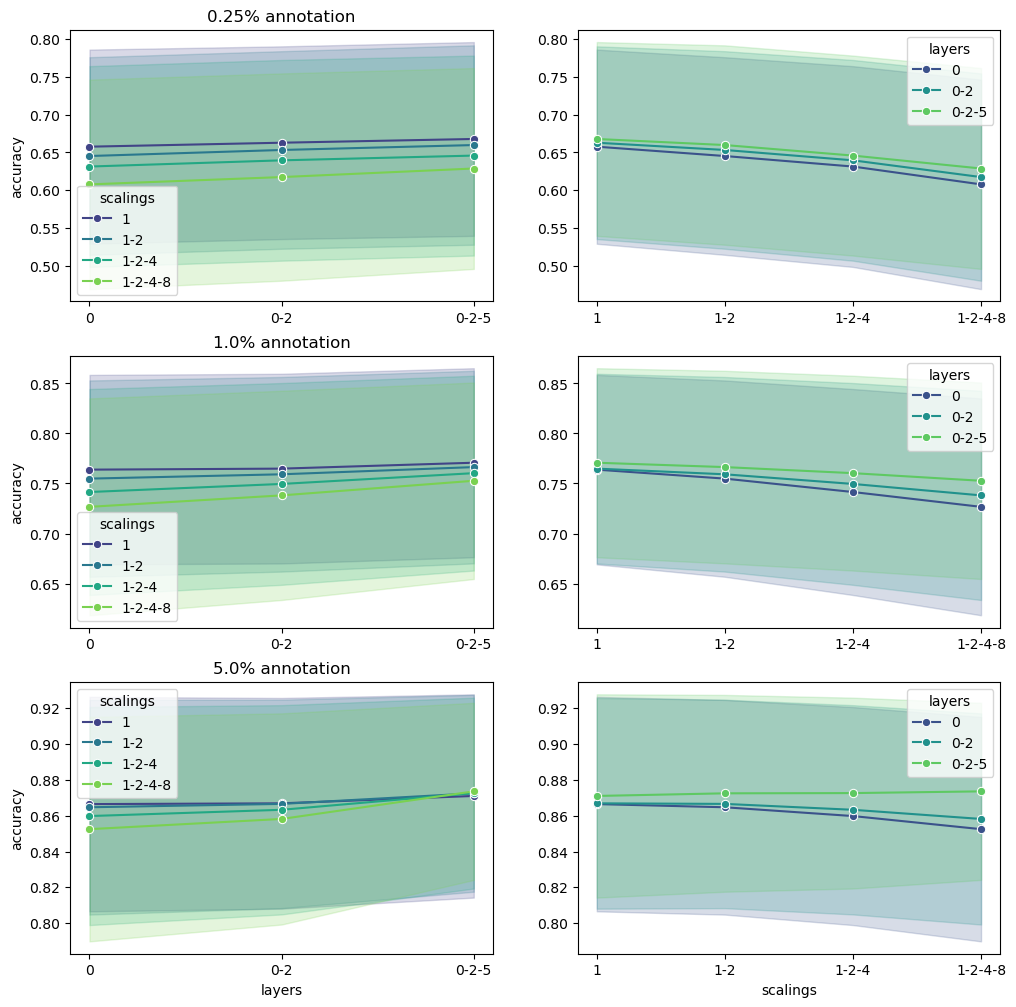

In [55]:
fig, ax = plt.subplots(3, 2)

fig.set_size_inches(12, 12)
fig.set_dpi(100)

for i, df in enumerate(df_list):
    row = ax[i]
    sns.lineplot(x='layers', y='accuracy', data=df, hue='scalings', palette='viridis', errorbar='sd', marker='o',ax=row[0])
    sns.lineplot(x='scalings', y='accuracy', data=df, hue='layers', palette='viridis', errorbar='sd', marker='o',ax=row[1])
    # Hide y axis label of right plot
    row[0].title.set_text(f"{title_list[i]}% annotation")
    row[1].set_ylabel('')
    if i != num_df-1:
        row[0].set_xlabel('')
        row[1].set_xlabel('')

FoodSeg103: Check if there is a correlation between the image resolution and the performance of different scalings for vgg16

In [ ]:
# To check if the calculations are correct, we can calculate the mean of the accuracy for the first layer and scaling for the first annotation bin and the first image
d = food_df_list_conv[0]
d = d[d['img_num'] == 0]
mean_of_scaling_1 = d.loc[(d['scalings'] == '1') & (d['layers'] == '0')]['accuracy'].mean()
mean_of_scaling_2 = d.loc[(d['scalings'] == '1-2-4-8') & (d['layers'] == '0')]['accuracy'].mean()
diff = mean_of_scaling_1 - mean_of_scaling_2
print(mean_of_scaling_1, mean_of_scaling_2, diff)

In [ ]:
scalings_to_comp = ['1', '1-2-4-8']
grouped_dfs = []
for df_conv_bin in food_df_list_conv:
    # df_conv_bin = df_conv_bin[df_conv_bin['layers']=='0']
    # Step 1: Group by 'img_num' and 'scalings' to compute average accuracy
    grouped_df = df_conv_bin.groupby(['img_num', 'scalings'])['accuracy'].mean().unstack()
    # grouped_df = df_conv_bin.groupby(['img_num'])['accuracy'].first()
    grouped_df['img_num'] = grouped_df.index
    # grouped_df = grouped_df.reset_index(drop=True)
    grouped_df['pix_in_img'] = df_conv_bin.groupby('img_num')['pix_in_img'].first().values
    grouped_df['accuracy_diff'] = grouped_df[scalings_to_comp[0]] - grouped_df[scalings_to_comp[1]]
    grouped_dfs.append(grouped_df)
# Display the result
grouped_dfs[0][:4]

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.set_dpi(100)
for i, grouped_df in enumerate(grouped_dfs):
    sns.scatterplot(x='pix_in_img', y='accuracy_diff', data=grouped_df, palette='viridis', s=20, alpha=0.5, ax=ax[i])
    # sns.scatterplot(x='pix_in_img', y='accuracy', data=grouped_df, palette='viridis', s=10, ax=ax)
    # ax[i].set_xscale('log')
    # ax[i].set_yscale('log')
    ax[i].set_xlabel('Total pixels in image')
    ax[i].set_ylabel('Accuracy diff. ("1" - "1-2-4-8" scalings)')
    ax[i].set_title(f'{food_annot_bins[i]}% annotation')
plt.show()

Create a heatmap with the different Convpaint models (layers and scalings)

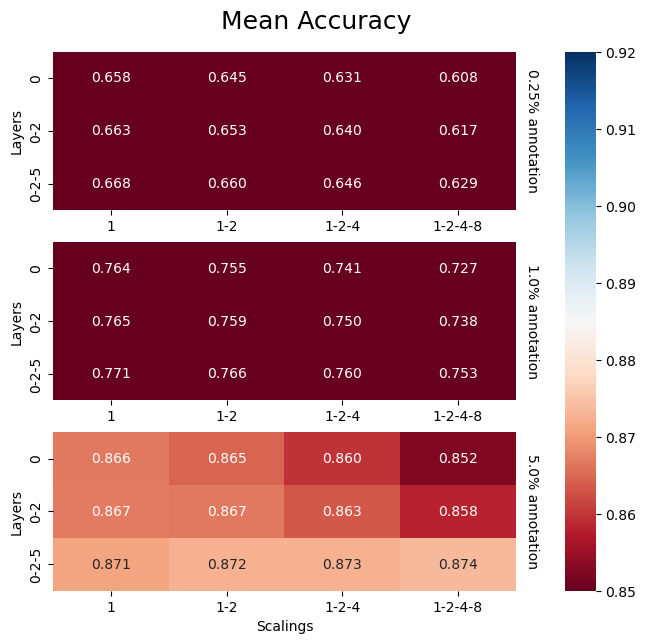

In [56]:
# fig, ax = plt.subplots(3, 1, gridspec_kw={'width_ratios': [15], 'height_ratios': [1, 0.15, 1]})
fig, ax = plt.subplot_mosaic([['upper left', 'right'],
                              ['mid left', 'right'],
                              ['lower left', 'right']],
                              gridspec_kw={'width_ratios': [15, 1]})
ax_list = [ax['upper left'], ax['mid left'], ax['lower left']]
fig.set_size_inches(7, 7)
fig.set_dpi(100)
fig.suptitle('Mean Accuracy', fontsize=18, y=0.94)
# fig.tight_layout()

for i, df in enumerate(df_list):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df[df['prediction type'].str.contains('convpaint')].pivot_table(index='layers', columns='scalings', values='accuracy')

    sns.heatmap(heatmap_df_mean, annot=True, cmap="RdBu", fmt=".3f", cbar=i==0, cbar_ax=ax['right'], ax=row, vmin=0.85, vmax=0.92)
    # row.set_title(f'{["0.1", "1.0"][i]}% annotation')
    row.text(1.02, 0.5, f'{title_list[i]}% annotation', transform=row.transAxes, rotation=270, va='center')
    row.set_xlabel('Scalings' if i == num_df - 1 else '')
    row.set_ylabel('Layers')

    # row.set_tight_layout()
    # row.set_aspect('auto')

# plt.savefig('FoodSeg103_results/avg_acc_convpaint.pdf', dpi=300)



### Convpaint models vs. Ilastik (and DINOv2) on same set of data

In [ ]:
# Confirm that the two test runs (pred04 with all images but only default convpaint and pred05/df010 with convpaint comparison) gave the same results
print(f"pred04 {pred04_010[pred04_010['prediction type'] == 'convpaint']['accuracy'].mean():.3f} = pred05 {df010[df010['prediction type']=='convpaint_l-0_s-1-2']['accuracy'].mean():.3f}")
print(f"pred04 {pred04_001[pred04_001['prediction type'] == 'convpaint']['accuracy'].mean():.3f} = pred05 {df001[df001['prediction type']=='convpaint_l-0_s-1-2']['accuracy'].mean():.3f}")

Cellpose: Extract Ilastik data

In [6]:
pred04_010 = df_orig.loc[(df_orig['scribbles bin'] == 1) & (df_orig['img_num'].isin(range(0, 540, 10)))]
pred04_001 = df_orig[(df_orig['scribbles bin'] == 0.1) & (df_orig['img_num'].isin(range(0, 540, 10)))]
# pred04_001 = df_orig[(df_orig['scribbles bin'] == 0.01) & (df_orig['img_num'].isin(range(0, 540, 10)))]

pred04 0.896 = pred05 0.896
pred04 0.871 = pred05 0.871


In [151]:
# Extract Ilastik results for the equivalent cases
ilastik_001 = df_run04[df_run04['prediction type'].str.contains('ilastik') & (df_run04['scribbles bin'] == 0.1)]
ilastik_010 = df_run04[df_run04['prediction type'].str.contains('ilastik') & (df_run04['scribbles bin'] == 1)]
ilastik_100 = df_run04[df_run04['prediction type'].str.contains('ilastik') & (df_run04['scribbles bin'] == 1.25)]
# ilastik_010 = pred04_010[pred04_010['prediction type']=='ilastik']
# ilastik_001 = pred04_001[pred04_001['prediction type']=='ilastik']
# ilastik_100 =  pd.read_csv("cellpose_results/pred07_240408151643.csv")
# print(f"Ilastik mean accuracy for 0.1% scribbles and every 10th image: {ilastik_001['accuracy'].mean():.3f}")
# print(f"Ilastik mean accuracy for 1% scribbles and every 10th image: {ilastik_010['accuracy'].mean():.3f}")
# print(f"Ilastik mean accuracy for 10% scribbles and every 10th image: {ilastik_100['accuracy'].mean():.3f}")
# Do the same for Convpaint to ensure that the results are the same
# convpaint_001 = pred04_001[pred04_001['prediction type']=='convpaint']
# convpaint_010 = pred04_010[pred04_010['prediction type']=='convpaint']
# convpaint_100 =  pd.read_csv("results/pred06_240403221657.csv")
# print(f"ConvPaint mean accuracy for 0.1% scribbles and every 10th image: {convpaint_001['accuracy'].mean():.3f}")
# print(f"ConvPaint mean accuracy for 1% scribbles and every 10th image: {convpaint_010['accuracy'].mean():.3f}")
# print(f"ConvPaint mean accuracy for 10% scribbles and every 10th image: {df100['accuracy'].mean():.3f}")

Cellpose: Read in DINOv2 results from pred08

In [152]:
df_dino = df_run04[df_run04['prediction type'].str.contains('dino')] #pd.read_csv("cellpose_results/pred08_240415192210.csv")
cellpose_df_list_dino = [df_dino[df_dino['scribbles bin'] == bin] for bin in [0.1, 1, 1.25]] #df_dino['scribbles bin'].unique()]
cellpose_df_list_dino[0][:5]

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,accuracy,image,ground truth,scribbles,prediction
55,0,dino,all,0.1,w1_run04,101577,94519,184,93,91,196096,0.093832,0.631410,/mnt/imaging.data/rschwob/cellpose_run04/000_i...,/mnt/imaging.data/rschwob/cellpose_run04/000_g...,/mnt/imaging.data/rschwob/cellpose_run04/000_s...,/mnt/imaging.data/rschwob/cellpose_run04/000_d...
167,1,dino,all,0.1,w1_run04,128463,67633,185,123,62,196096,0.094342,0.741448,/mnt/imaging.data/rschwob/cellpose_run04/001_i...,/mnt/imaging.data/rschwob/cellpose_run04/001_g...,/mnt/imaging.data/rschwob/cellpose_run04/001_s...,/mnt/imaging.data/rschwob/cellpose_run04/001_d...
279,2,dino,all,0.1,w1_run04,115332,80764,176,101,75,196096,0.089752,0.728317,/mnt/imaging.data/rschwob/cellpose_run04/002_i...,/mnt/imaging.data/rschwob/cellpose_run04/002_g...,/mnt/imaging.data/rschwob/cellpose_run04/002_s...,/mnt/imaging.data/rschwob/cellpose_run04/002_d...
391,3,dino,all,0.1,w1_run04,124721,71375,183,119,64,196096,0.093322,0.764411,/mnt/imaging.data/rschwob/cellpose_run04/003_i...,/mnt/imaging.data/rschwob/cellpose_run04/003_g...,/mnt/imaging.data/rschwob/cellpose_run04/003_s...,/mnt/imaging.data/rschwob/cellpose_run04/003_d...
503,4,dino,all,0.1,w1_run04,115615,80481,181,106,75,196096,0.092302,0.754773,/mnt/imaging.data/rschwob/cellpose_run04/004_i...,/mnt/imaging.data/rschwob/cellpose_run04/004_g...,/mnt/imaging.data/rschwob/cellpose_run04/004_s...,/mnt/imaging.data/rschwob/cellpose_run04/004_d...


Define what data to use

In [57]:
# Cellpose
# title_list = [0.1, 1, 10]
# df_list_conv = [df001, df010, df100]
# df_list_ila = [ilastik_001, ilastik_010, ilastik_100]
# df_list_dino = cellpose_df_list_dino

# FoodSeg103
title_list = food_annot_bins
df_list_conv = food_df_list_conv
df_list_ila = food_df_list_ilastik
df_list_dino = food_df_list_dino

num_df = len(df_list_conv)

Create Heatmap

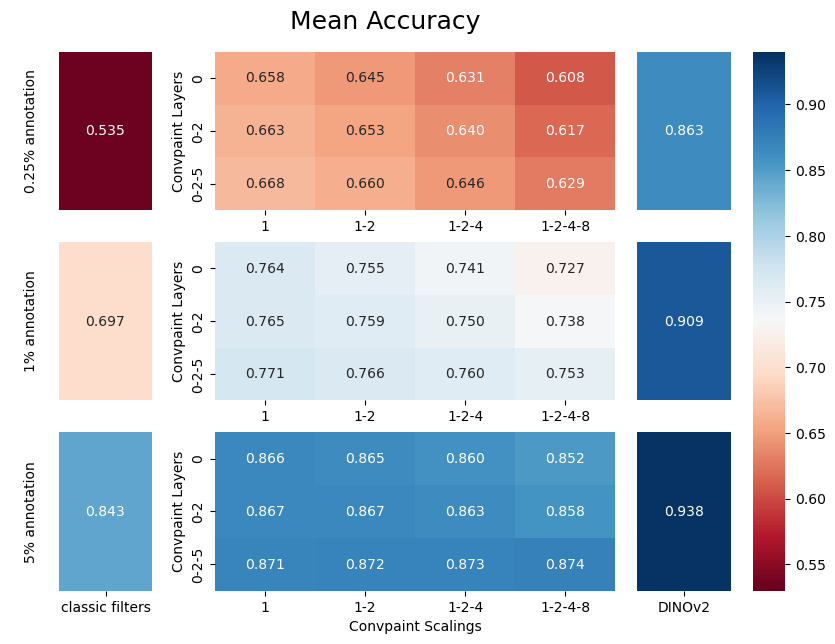

In [61]:
# With two models
# fig, ax = plt.subplot_mosaic([['upper left', 'upper mid', 'pad', 'right'],
#                               ['mid left', 'mid mid', 'pad', 'right'],
#                               ['lower left', 'lower mid', 'pad', 'right']],
#                               gridspec_kw={'width_ratios': [15, 3.5, 0.3, 1.2]})

# With three models
fig, ax = plt.subplot_mosaic([['pad left', 'upper left', 'pad', 'upper mid', 'upper right', 'right'],
                              ['pad left', 'mid left', 'pad', 'mid mid', 'mid right', 'right'],
                              ['pad left', 'lower left', 'pad', 'lower mid', 'lower right', 'right']],
                              gridspec_kw={'width_ratios': [1, 3.5, 0.7, 15, 3.5, 1.2]})

# Set parameters                        
for pad in ['pad left', 'pad']: ax[pad].axis('off')
fig.set_size_inches(10, 7)
fig.set_dpi(100)
fig.suptitle('Mean Accuracy', fontsize=18, y=0.94)
heatmap_cfg = {"annot":True, "cmap":"RdBu", "fmt":".3f", "cbar_ax":ax['right'], "vmin":0.53, "vmax":0.94}
# original cmap = 'YlGnBu'; good alternatives: RdBu, twilight_shifted
# fig.tight_layout()

# CONVPAINT
ax_list_conv = [ax['upper mid'], ax['mid mid'], ax['lower mid']]#[ax['upper left'], ax['mid left'], ax['lower left']]
for i, df in enumerate(df_list_conv):
    row = ax_list_conv[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values='accuracy')
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('Convpaint Scalings' if i == num_df - 1 else '')
    # row.set_yticks([])
    row.set_ylabel('Convpaint Layers')

    # row.set_tight_layout()
    # row.set_aspect('auto')

# ILASTIK
ax_list_ila = [ax['upper left'], ax['mid left'], ax['lower left']] #[ax['upper mid'], ax['mid mid'], ax['lower mid']]
for i, df in enumerate(df_list_ila):
    row = ax_list_ila[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df['accuracy'].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_df - 1:
        row.set_xticklabels(["classic filters"])
    else:
        row.set_xticks([])
    row.set_yticks([])
    row.text(-0.37, 0.5, f'{int(title_list[i]) if int(title_list[i]) == title_list[i] else title_list[i]}% annotation', transform=row.transAxes, rotation=90, va='center')

# DINOv2
ax_list_dino = [ax['upper right'], ax['mid right'], ax['lower right']]
for i, df in enumerate(df_list_dino):
    row = ax_list_dino[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df['accuracy'].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_df - 1:
        row.set_xticklabels(["DINOv2"])
    else:
        row.set_xticks([])
    row.set_yticks([])

# plt.savefig('cellpose_results/avg_acc.pdf', dpi=300)
# plt.savefig('FoodSeg103_results/avg_acc.pdf', dpi=300)